In [2]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
import os

print("✅ All imports successful")

✅ All imports successful


In [3]:
# Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded successfully")

✅ API key loaded successfully


In [4]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [5]:
# System prompt that defines assistant behavior
sys_msg = SystemMessage(
    content="You are a friendly assistant that answers user questions. Be helpful and concise."
)

def assistant(state: MessagesState) -> dict:
    """
    The assistant node - processes messages and generates response.
    """
    # Combine system prompt with conversation history
    messages = [sys_msg] + state["messages"]
    
    # Get response from LLM
    response = llm.invoke(messages)
    
    # Return as state update
    return {"messages": [AIMessage(content=response.content)]}

print("✅ Assistant node defined")

✅ Assistant node defined


In [6]:
def retrieve_docs(state: MessagesState):
    query = state["messages"][-1].content  # latest HumanMessage
    docs = retriever.invoke(query)

    return {
        "messages": [
            ToolMessage(
                content="\n".join(d.page_content for d in docs),
                name="retriever"
            )
        ]
    }

In [7]:
# Create a StateGraph with MessagesState
builder = StateGraph(MessagesState)

# Add the assistant node
builder.add_node("assistant", assistant)

# Define the flow:
# START → assistant → END
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

print("✅ Graph structure defined")

✅ Graph structure defined


In [8]:
# Create a memory checkpointer (stores in memory)
memory = MemorySaver()

# Compile the graph WITH memory
agent = builder.compile(checkpointer=memory)

print("✅ Agent compiled with memory")

✅ Agent compiled with memory


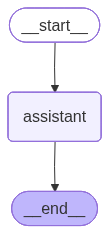

In [9]:
# Visualize the graph structure
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → END")

In [11]:
# Define a session ID for this conversation
session_id = "chat-session-0013"

print(f"Starting conversation with session ID: {session_id}")

Starting conversation with session ID: chat-session-0013


In [12]:
def run_conversation(user_input: str, thread_id: str = session_id):
    """
    Send a message to the agent and get response.
    ⚠️ WARNING: Using default thread_id shares conversation acrosss all calls!
    In production, ALWAYS provide unique thread_id per user.
    """
    # Invoke the agent
    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )
    
    # Print the conversation
    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            print(f"\n👤 User: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"🤖 Agent: {message.content}")
    
    print("\n" + "="*70)

print("✅ Conversation function ready")

✅ Conversation function ready


In [13]:
run_conversation("Hello!")


👤 User: Hello!
🤖 Agent: Hello! How can I assist you today?



In [16]:
# First message
run_conversation("I do not have a favorite color")


👤 User: Hello!
🤖 Agent: Hello! How can I assist you today?

👤 User: My favorite color is blue
🤖 Agent: That's great! Blue is a calming and soothing color. Do you have a particular shade of blue that you like best?

👤 User: What's my favorite color?
🤖 Agent: Your favorite color is blue!

👤 User: I do not have a favorite color
🤖 Agent: That's perfectly fine! Not everyone has a favorite color. Is there something else you'd like to talk about or ask?



In [17]:
# Follow-up question - does it remember?
run_conversation("What's my favorite color?")


👤 User: Hello!
🤖 Agent: Hello! How can I assist you today?

👤 User: My favorite color is blue
🤖 Agent: That's great! Blue is a calming and soothing color. Do you have a particular shade of blue that you like best?

👤 User: What's my favorite color?
🤖 Agent: Your favorite color is blue!

👤 User: I do not have a favorite color
🤖 Agent: That's perfectly fine! Not everyone has a favorite color. Is there something else you'd like to talk about or ask?

👤 User: What's my favorite color?
🤖 Agent: You mentioned earlier that your favorite color is blue, but you also said you don't have a favorite color. So, it seems you might not have one!



In [18]:
run_conversation("What's my favorite color?", thread_id="111")


👤 User: What's my favorite color?
🤖 Agent: I don’t know your favorite color, but I’d love to hear about it if you want to share!



In [19]:
# Start a new topic
run_conversation("I'm learning about RAG systems")


👤 User: Hello!
🤖 Agent: Hello! How can I assist you today?

👤 User: My favorite color is blue
🤖 Agent: That's great! Blue is a calming and soothing color. Do you have a particular shade of blue that you like best?

👤 User: What's my favorite color?
🤖 Agent: Your favorite color is blue!

👤 User: I do not have a favorite color
🤖 Agent: That's perfectly fine! Not everyone has a favorite color. Is there something else you'd like to talk about or ask?

👤 User: What's my favorite color?
🤖 Agent: You mentioned earlier that your favorite color is blue, but you also said you don't have a favorite color. So, it seems you might not have one!

👤 User: I'm learning about RAG systems
🤖 Agent: That's interesting! RAG (Retrieval-Augmented Generation) systems combine retrieval of information from a database or knowledge base with generative models to produce more accurate and contextually relevant answers. They typically involve two main components: a retriever that fetches relevant documents or data 

In [20]:
# Reference it
run_conversation("Can you explain the main components?")


👤 User: Hello!
🤖 Agent: Hello! How can I assist you today?

👤 User: My favorite color is blue
🤖 Agent: That's great! Blue is a calming and soothing color. Do you have a particular shade of blue that you like best?

👤 User: What's my favorite color?
🤖 Agent: Your favorite color is blue!

👤 User: I do not have a favorite color
🤖 Agent: That's perfectly fine! Not everyone has a favorite color. Is there something else you'd like to talk about or ask?

👤 User: What's my favorite color?
🤖 Agent: You mentioned earlier that your favorite color is blue, but you also said you don't have a favorite color. So, it seems you might not have one!

👤 User: I'm learning about RAG systems
🤖 Agent: That's interesting! RAG (Retrieval-Augmented Generation) systems combine retrieval of information from a database or knowledge base with generative models to produce more accurate and contextually relevant answers. They typically involve two main components: a retriever that fetches relevant documents or data 

In [21]:
# Follow-up question
run_conversation("Which component is most important?")


👤 User: Hello!
🤖 Agent: Hello! How can I assist you today?

👤 User: My favorite color is blue
🤖 Agent: That's great! Blue is a calming and soothing color. Do you have a particular shade of blue that you like best?

👤 User: What's my favorite color?
🤖 Agent: Your favorite color is blue!

👤 User: I do not have a favorite color
🤖 Agent: That's perfectly fine! Not everyone has a favorite color. Is there something else you'd like to talk about or ask?

👤 User: What's my favorite color?
🤖 Agent: You mentioned earlier that your favorite color is blue, but you also said you don't have a favorite color. So, it seems you might not have one!

👤 User: I'm learning about RAG systems
🤖 Agent: That's interesting! RAG (Retrieval-Augmented Generation) systems combine retrieval of information from a database or knowledge base with generative models to produce more accurate and contextually relevant answers. They typically involve two main components: a retriever that fetches relevant documents or data 

In [22]:
# Conversation 1
print("\n🔵 CONVERSATION 1")
run_conversation("My name is Alice", thread_id="user_alicee")

# Conversation 2 (different user)
print("\n🟢 CONVERSATION 2")
run_conversation("My name is Bob", thread_id="user_bobb")


🔵 CONVERSATION 1

👤 User: My name is Alice
🤖 Agent: Nice to meet you, Alice! How can I assist you today?


🟢 CONVERSATION 2

👤 User: My name is Bob
🤖 Agent: Nice to meet you, Bob! How can I assist you today?



In [23]:
# Back to Alice - does it remember her name?
print("\n🔵 BACK TO CONVERSATION 1")
run_conversation("What's my name?", thread_id="user_alicee")


🔵 BACK TO CONVERSATION 1

👤 User: My name is Alice
🤖 Agent: Nice to meet you, Alice! How can I assist you today?

👤 User: What's my name?
🤖 Agent: Your name is Alice! How can I help you today?



In [28]:
# Back to Bob
print("\n🟢 BACK TO CONVERSATION 2")
run_conversation("What's my name?", thread_id="user_bobb")


🟢 BACK TO CONVERSATION 2

👤 User: My name is Bob
🤖 Agent: Nice to meet you, Bob! How can I assist you today?

👤 User: What's my name?
🤖 Agent: Your name is Bob! How can I help you today?

👤 User: What's my name?
🤖 Agent: Your name is Bob. Is there something specific you would like to know or discuss?



In [29]:
def interactive_chat():
    """
    Run an interactive chat session.
    Type 'exit' or 'quit' to stop.
    """
    print("\n" + "="*70)
    print("🤖 Interactive Chat Started")
    print("Type your message and press Enter. Type 'exit' to quit.")
    print("="*70 + "\n")
    
    thread_id = "interactive_session2"
    
    while True:
        user_input = input("\n👤 You: ").strip()
        
        if user_input.lower() in ["exit", "quit"]:
            print("\n👋 Goodbye!\n")
            break
        
        if not user_input:
            continue
        
        # Get response
        result = agent.invoke(
            {"messages": [HumanMessage(content=user_input)]},
            config={"configurable": {"thread_id": thread_id}}
        )
        
        # Print agent's response
        agent_message = result["messages"][-1]
        print(f"\n🤖 Agent: {agent_message.content}")

# Uncomment to run interactive chat:
interactive_chat()


🤖 Interactive Chat Started
Type your message and press Enter. Type 'exit' to quit.


🤖 Agent: Hello! How can I assist you today?

🤖 Agent: Forex trading, or foreign exchange trading, involves buying and selling currencies in the foreign exchange market. Here are some key points:

1. **Currency Pairs**: Forex trading is always done in pairs (e.g., EUR/USD). You buy one currency while selling another.

2. **Market Hours**: The Forex market operates 24 hours a day, five days a week, allowing for flexibility in trading.

3. **Leverage**: Forex brokers often offer leverage, allowing traders to control larger positions with a smaller amount of capital. This can amplify gains but also increases risk.

4. **Pips and Lots**: Price movements in Forex are measured in pips (the smallest price move), and trades are typically made in lots (standard, mini, or micro).

5. **Types of Analysis**: Traders use technical analysis (charts and indicators) and fundamental analysis (economic news and events) 

### Topic 2 - Tool Integration for Agents

In [30]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal
import os

print("✅ All imports successful")

✅ All imports successful


In [31]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded")

✅ API key loaded


In [32]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,  # Lower temperature for more precise tool usage
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [33]:
@tool
def calculator(expression: str) -> str:
    """
    Evaluate a mathematical expression and return the result.
    Use this tool when you need to perform calculations.
    
    Args:
        expression: A mathematical expression like "2 + 2" or "15 * 37"
        
    Returns:
        The calculated result as a string
        
    Examples:
        - "2 + 2" returns "4"
        - "100 / 5" returns "20.0"
        - "2 ** 10" returns "1024"
    """
    try:
        # Evaluate the expression safely
        result = eval(expression, {"__builtins__": {}}, {})
        return str(result)
    except Exception as e:
        return f"Error calculating: {str(e)}"

print("✅ Calculator tool created")

✅ Calculator tool created


In [34]:
# Test the calculator tool
result = calculator.invoke({"expression": "123 * 456"})
print(f"123 * 456 = {result}")

result2 = calculator.invoke("2 ** 10")
print(f"2^10 = {result2}")

123 * 456 = 56088
2^10 = 1024


In [35]:
@tool
def text_analyzer(text: str) -> str:
    """
    Analyze text and return statistics about it.
    Use this tool when you need to analyze or count things in text.
    
    Args:
        text: The text to analyze
        
    Returns:
        Statistics about the text (characters, words, sentences)
        
    Examples:
        - "Hello world" returns character count, word count, etc.
    """
    char_count = len(text)
    word_count = len(text.split())
    sentence_count = text.count('.') + text.count('!') + text.count('?')
    
    return f"""Text Analysis:
- Characters: {char_count}
- Words: {word_count}
- Sentences: {sentence_count}
- First 50 chars: {text[:50]}..."""

print("✅ Text analyzer tool created")

✅ Text analyzer tool created


In [36]:
# Test the text analyzer
test_text = "Hello! This is a test. How are you today?"
result = text_analyzer.invoke({"text": test_text})
print(result)

Text Analysis:
- Characters: 41
- Words: 9
- Sentences: 3
- First 50 chars: Hello! This is a test. How are you today?...


In [37]:
# Create a list of tools
tools = [calculator, text_analyzer]

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

print(f"✅ LLM bound to {len(tools)} tools")
print(f"   Tools: {[tool.name for tool in tools]}")

✅ LLM bound to 2 tools
   Tools: ['calculator', 'text_analyzer']


In [38]:
# Test: Does LLM decide to call calculator?
response = llm_with_tools.invoke([HumanMessage(content="What is 234 * 567?")])

print(f"Response type: {type(response)}")
print(f"\nContent: {response.content}")
print(f"\nTool calls: {response.tool_calls}")

Response type: <class 'langchain_core.messages.ai.AIMessage'>

Content: 

Tool calls: [{'name': 'calculator', 'args': {'expression': '234 * 567'}, 'id': 'call_8cRA3jc4k1DBPHYElCv8TAXy', 'type': 'tool_call'}]


In [39]:
# Test: Does LLM decide NOT to call tools for simple queries?
response2 = llm_with_tools.invoke([HumanMessage(content="Hello! How are you?")])

print(f"Content: {response2.content}")
print(f"Tool calls: {response2.tool_calls}")

Content: Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?
Tool calls: []


In [40]:
# System prompt that encourages tool usage
sys_msg = SystemMessage(content="""You are a helpful assistant with access to tools.

When asked to perform calculations, use the calculator tool.
When asked to analyze text, use the text_analyzer tool.

Only use tools when necessary - for simple questions, answer directly.""")

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to use tools or answer directly.
    """
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

print("✅ Assistant node defined")

✅ Assistant node defined


In [41]:
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide next step based on last message.
    
    If LLM called a tool → go to 'tools' node
    If LLM provided final answer → go to END
    """
    last_message = state["messages"][-1]
    
    # Check if LLM made tool calls
    if last_message.tool_calls:
        return "tools"
    
    # No tool calls - we're done
    return "__end__"

print("✅ Conditional routing function defined")

✅ Conditional routing function defined


In [42]:
# Create the graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))  # ToolNode executes tool calls automatically

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")  # After tools, go back to assistant

# Add memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

print("✅ Agent graph compiled with tools and memory")

✅ Agent graph compiled with tools and memory


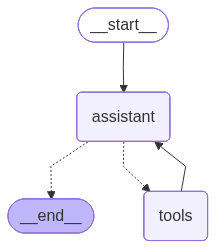

In [44]:
# Visualize the agent graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → [conditional] → tools → assistant → END")

In [45]:
# Helper function
def run_agent(user_input: str, thread_id: str = "test_session"):
    """
    Run the agent and display the conversation.
    """
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")
    
    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )
    
    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            continue  # Already printed
        elif isinstance(message, AIMessage):
            if message.tool_calls:
                print(f"🤖 Agent: [Calling tool: {message.tool_calls[0]['name']}]")
            else:
                print(f"🤖 Agent: {message.content}")
        elif isinstance(message, ToolMessage):
            print(f"🔧 Tool Result: {message.content[:100]}..." if len(message.content) > 100 else f"🔧 Tool Result: {message.content}")
    
    print(f"\n{'='*70}\n")

print("✅ Test function ready")

✅ Test function ready


In [46]:
run_agent("What is 12345 * 67890?")


👤 User: What is 12345 * 67890?

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of \( 12345 \times 67890 \) is 838,102,050.




In [47]:
run_agent("Analyze this text: 'RAG systems combine retrieval with generation. They are very useful!'")


👤 User: Analyze this text: 'RAG systems combine retrieval with generation. They are very useful!'

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of \( 12345 \times 67890 \) is 838,102,050.
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
🤖 Agent: Here is the analysis of the text:

- **Characters**: 68
- **Words**: 10
- **Sentences**: 2
- **First 50 characters**: "RAG systems combine retrieval with generation. The..."




In [48]:
run_agent("Hello! What can you help me with?")


👤 User: Hello! What can you help me with?

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of \( 12345 \times 67890 \) is 838,102,050.
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
🤖 Agent: Here is the analysis of the text:

- **Characters**: 68
- **Words**: 10
- **Sentences**: 2
- **First 50 characters**: "RAG systems combine retrieval with generation. The..."
🤖 Agent: Hello! I can assist you with a variety of tasks, including:

1. **Mathematical Calculations**: I can perform calculations and solve mathematical expressions.
2. **Text Analysis**: I can analyze text for statistics such as character count, word count, and sentence count.
3. **General Information**: I can provide information on a wide range of topics.

Feel free to ask me anything specific you'd like help with!




In [49]:
run_agent("How many words are in this sentence: 'LangGraph makes building agents easy'?")


👤 User: How many words are in this sentence: 'LangGraph makes building agents easy'?

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of \( 12345 \times 67890 \) is 838,102,050.
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
🤖 Agent: Here is the analysis of the text:

- **Characters**: 68
- **Words**: 10
- **Sentences**: 2
- **First 50 characters**: "RAG systems combine retrieval with generation. The..."
🤖 Agent: Hello! I can assist you with a variety of tasks, including:

1. **Mathematical Calculations**: I can perform calculations and solve mathematical expressions.
2. **Text Analysis**: I can analyze text for statistics such as character count, word count, and sentence count.
3. **General Information**: I can provide information on a wide range of topics.

Feel free to ask me anything specific you'd like help with!
🤖 Agent: [Calling tool: t

In [50]:
# First query
run_agent("Calculate 100 * 50", thread_id="calc_session")


👤 User: Calculate 100 * 50

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 5000
🤖 Agent: The result of \( 100 \times 50 \) is 5000.




In [51]:
# Follow-up - does it remember?
run_agent("Now add 1000 to that result", thread_id="calc_session")


👤 User: Now add 1000 to that result

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 5000
🤖 Agent: The result of \( 100 \times 50 \) is 5000.
🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 6000
🤖 Agent: Adding 1000 to the previous result gives us 6000.


